## Fairness Analysis of NamSor's Gender API Endpoint using Aequitas

Part I: Fairness of Gender API Endpoint by Gender and Ethnicity

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import pdfkit as pdf

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_ethnicity_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,race,race_pred,sex,score,label_value
0,0,1,miguel,hernandez,Other,Hispanic,Male,0.024501,0.0
1,1,3,kevon,dixon,African-American,African-American,Male,0.142035,1.0
2,2,4,ed,philo,African-American,Asian,Male,0.388947,0.0
3,3,5,marcu,brown,African-American,African-American,Male,0.235928,1.0
4,4,6,bouthy,pierrelouis,Other,African-American,Male,0.199168,0.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,race,race_pred,sex,score,label_value
0,1,miguel,hernandez,Other,Hispanic,Male,0.024501,0.0
1,3,kevon,dixon,African-American,African-American,Male,0.142035,1.0
2,4,ed,philo,African-American,Asian,Male,0.388947,0.0
3,5,marcu,brown,African-American,African-American,Male,0.235928,1.0
4,6,bouthy,pierrelouis,Other,African-American,Male,0.199168,0.0


In [5]:
# we only want to look at ethnicity here, since that is what we calculated label_value for
df = df.drop(['race_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
# now we remove groups that are too small
df = df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])]

In [7]:
df.shape

(6787, 5)

In [8]:
df["combined_attribute"] = df["sex"] + " " + df["race"]

In [9]:
df.head()

,entity_id,race,sex,score,label_value,combined_attribute
1,3,African-American,Male,0.142035,1.0,Male African-American
2,4,African-American,Male,0.388947,0.0,Male African-American
3,5,African-American,Male,0.235928,1.0,Male African-American
6,8,Caucasian,Male,0.238652,1.0,Male Caucasian
8,10,Caucasian,Female,0.233335,1.0,Female Caucasian


## Group Metrics
First, let's calculate the group metrics like tp, fn, and so on. For determining which score is considered to be a prediction of the classification being correct we will use a score treshold that is the maximum score, or minimum probabilityCalibrated. We do this, because NamSor does make a prediction starting at that score and we want to look at the raw prediction first. We will look at different scores later on to see which score produces which fairness.

In [10]:
t = df[["score"]].max()[0]
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["sex", "race", "combined_attribute"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.640602528346385]}


In [11]:
df[["score"]].max()[0]

0.640602528346385

In [12]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.640602528346385_ore,6787,sex,Female,1322,0,388,0,0,934,934,388,1322,6787
1,0,0.640602528346385_ore,6787,sex,Male,5465,0,1581,0,0,3884,3884,1581,5465,6787
2,0,0.640602528346385_ore,6787,race,African-American,3696,0,906,0,0,2790,2790,906,3696,6787
3,0,0.640602528346385_ore,6787,race,Caucasian,2454,0,1017,0,0,1437,1437,1017,2454,6787
4,0,0.640602528346385_ore,6787,race,Hispanic,637,0,46,0,0,591,591,46,637,6787
5,0,0.640602528346385_ore,6787,combined_attribute,Female African-American,652,0,105,0,0,547,547,105,652,6787
6,0,0.640602528346385_ore,6787,combined_attribute,Female Caucasian,567,0,271,0,0,296,296,271,567,6787
7,0,0.640602528346385_ore,6787,combined_attribute,Female Hispanic,103,0,12,0,0,91,91,12,103,6787
8,0,0.640602528346385_ore,6787,combined_attribute,Male African-American,3044,0,801,0,0,2243,2243,801,3044,6787
9,0,0.640602528346385_ore,6787,combined_attribute,Male Caucasian,1887,0,746,0,0,1141,1141,746,1887,6787


In [13]:
def _color_red_or_green_or_orange(val): # https://stackoverflow.com/questions/28075699/coloring-cells-in-pandas
    try:
        if(val > 0.8 and val < 1.2):
            color = 'green'
        elif(val < 0.8):
            color = 'orange'
        else: color = 'red'
        return 'color: %s' % color
    except:
        return 'color: black'

In [14]:
xtab.columns

Index(['model_id', 'score_threshold', 'k', 'attribute_name', 'attribute_value',
       'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv', 'precision', 'pp',
       'pn', 'ppr', 'pprev', 'fp', 'fn', 'tn', 'tp', 'group_label_pos',
       'group_label_neg', 'group_size', 'total_entities', 'prev'],
      dtype='object')

In [15]:
xtab #[['attribute_name', 'attribute_value'] + absolute_metrics]

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.640602528346385_ore,6787,sex,Female,1.0,0.0,NaN,0.293495,1.0,...,1.0,388,0,0,934,934,388,1322,6787,0.706505
1,0,0.640602528346385_ore,6787,sex,Male,1.0,0.0,NaN,0.289296,1.0,...,1.0,1581,0,0,3884,3884,1581,5465,6787,0.710704
2,0,0.640602528346385_ore,6787,race,African-American,1.0,0.0,NaN,0.245130,1.0,...,1.0,906,0,0,2790,2790,906,3696,6787,0.754870
3,0,0.640602528346385_ore,6787,race,Caucasian,1.0,0.0,NaN,0.414425,1.0,...,1.0,1017,0,0,1437,1437,1017,2454,6787,0.585575
4,0,0.640602528346385_ore,6787,race,Hispanic,1.0,0.0,NaN,0.072214,1.0,...,1.0,46,0,0,591,591,46,637,6787,0.927786
5,0,0.640602528346385_ore,6787,combined_attribute,Female African-American,1.0,0.0,NaN,0.161043,1.0,...,1.0,105,0,0,547,547,105,652,6787,0.838957
6,0,0.640602528346385_ore,6787,combined_attribute,Female Caucasian,1.0,0.0,NaN,0.477954,1.0,...,1.0,271,0,0,296,296,271,567,6787,0.522046
7,0,0.640602528346385_ore,6787,combined_attribute,Female Hispanic,1.0,0.0,NaN,0.116505,1.0,...,1.0,12,0,0,91,91,12,103,6787,0.883495
8,0,0.640602528346385_ore,6787,combined_attribute,Male African-American,1.0,0.0,NaN,0.263141,1.0,...,1.0,801,0,0,2243,2243,801,3044,6787,0.736859
9,0,0.640602528346385_ore,6787,combined_attribute,Male Caucasian,1.0,0.0,NaN,0.395337,1.0,...,1.0,746,0,0,1141,1141,746,1887,6787,0.604663


## Disparities of Group Metrics

In [16]:
#aq_palette = sns.diverging_palette(240, 10, n=9) #sns.diverging_palette(225, 35, n=2)
b = Bias()

In [17]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'sex':'Male', 'race':'Caucasian', 'combined_attribute':'Male Caucasian'})

bdf_overview = bdf[["attribute_name", "attribute_value", "precision_disparity", "fdr_disparity"]]

bdf_overview.style.applymap(_color_red_or_green_or_orange) #

get_disparity_predefined_group()


,attribute_name,attribute_value,precision_disparity,fdr_disparity
0,sex,Female,0.994092,1.01452
1,sex,Male,1,1
2,race,African-American,1.28911,0.591493
3,race,Caucasian,1,1
4,race,Hispanic,1.5844,0.17425
5,combined_attribute,Female African-American,1.38748,0.407357
6,combined_attribute,Female Caucasian,0.863366,1.20898
7,combined_attribute,Female Hispanic,1.46114,0.294698
8,combined_attribute,Male African-American,1.21863,0.665612
9,combined_attribute,Male Caucasian,1,1


## Fairness Metrics

In [18]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [19]:
def _color_red_or_green(val): # https://stackoverflow.com/questions/28075699/coloring-cells-in-pandas
    color = 'green' if val else 'red'
    return 'color: %s' % color

In [20]:
fdf[["attribute_name", "attribute_value", "Impact Parity", "Precision Parity", "FDR Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity"]].style.applymap(_color_red_or_green)

,attribute_name,attribute_value,Impact Parity,Precision Parity,FDR Parity,FPR Parity,TPR Parity,Equalized Odds,TypeI Parity
0,sex,Female,True,True,True,True,True,True,True
1,sex,Male,True,True,True,True,True,True,True
2,race,African-American,True,False,False,True,True,True,False
3,race,Caucasian,True,True,True,True,True,True,True
4,race,Hispanic,True,False,False,True,True,True,False
5,combined_attribute,Female African-American,True,False,False,True,True,True,False
6,combined_attribute,Female Caucasian,True,True,True,True,True,True,True
7,combined_attribute,Female Hispanic,True,False,False,True,True,True,False
8,combined_attribute,Male African-American,True,True,False,True,True,True,False
9,combined_attribute,Male Caucasian,True,True,True,True,True,True,True


In [21]:
gaf = f.get_group_attribute_fairness(fdf.fillna(True))
gaf[["attribute_name", "Impact Parity", "Precision Parity", "FDR Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity"]].style.applymap(_color_red_or_green)

,attribute_name,Impact Parity,Precision Parity,FDR Parity,FPR Parity,TPR Parity,Equalized Odds,TypeI Parity
0,combined_attribute,True,False,False,True,True,True,False
1,race,True,False,False,True,True,True,False
2,sex,True,True,True,True,True,True,True


In [22]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [23]:
xtab[['attribute_value'] + absolute_metrics].round(2).to_latex('graphics/group_metrics_maxthreshold_ethnicity.tex')
fdf[["attribute_value", "ppr_disparity", "pprev_disparity", "precision_disparity", "fdr_disparity", "fpr_disparity", "tpr_disparity"]].round(2).to_latex('graphics/disparities_maxthreshold_ethnicity.tex')
fdf[["attribute_value", "Impact Parity", "Precision Parity", "FPR Parity", "TPR Parity", "Equalized Odds", "TypeI Parity", "Unsupervised Fairness"]].to_latex('graphics/fairness_maxthreshold_ethnicity.tex')

### Analysis
We find that:
* PPREV or **Impact Parity**
* PPV- or Precision- or **Predictive Parity** only on a high level between Men and Women or on subgroup level between Caucasian men and Caucasian women
* TPR- or Recall Parity or **Equal Opportunity**
* **Equalized Odds** (TPR and FPR) 
* **Predictive Equality** (FPR) 
* **Equal Opportunity** (TPR) 

There is no:
* PPV- or Precision- or **Predictive Parity** (the colors are confusing here - if there is PPV Parity there has to be FDR Parity also) for groups other than Caucasian
* Because of Equal Opportunity and limited Predictive Equality there is also limited **Overall Accuracy Equality**
* Because of PPV/Predictive Parity and limited FPR/Predictive Equality there is also limited **Type I**
* PPR- or Demographic- or **Statistical Parity**
* Because of Impact Parity but no Statistical Parity, there is no **Unsupervised Fairness**.
These last two depend on a representative data set, which we have not. However

The unfairness does not negatively impact the concerned groups but if looking at the disparities, one can see that all groups except Caucasian women obtain **more precise** results than Caucasian men, the reference group. Therefore, one could say that the ethnicity API endpoint is actually biased against Caucasians. It seems to be harder to infer the ethnicity of Caucasians.

Not measured:
* FOR Parity
* Type II Parity (FNR/Equal Opportunity and FOR Parity)
* Supervised Fairness (Type I and II Parity)

## Impact of Treshold chosen
Now we will check whether chosing different tresholds results in different fairness.

In [24]:
from numpy import arange

disparities_res = pd.DataFrame({'model_id' : []})
fairness_res = pd.DataFrame({'model_id' : []})
overall_fairness_res = pd.DataFrame({'model_id' : []})
all_tables = []
complete_tables = []

g = Group()

tresholds = arange(0.1, 0.5, 0.1)
for t in tresholds:
    xtab, _ = g.get_crosstabs(df, 
                              attr_cols=["combined_attribute"], 
                              score_thresholds= {'score': [t]})
    absolute_metrics = g.list_absolute_metrics(xtab)
    
    b = Bias()
    bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                            ref_groups_dict={'combined_attribute':'Male Caucasian'}, 
                                            input_group_metrics=["ppr", "tpr", "fpr", "precision", "tnr", "npv", "pprev", "for", "fdr", "fnr"],
                                            check_significance=False, 
                                            mask_significance=False)
    
    f = Fairness()
    fdf = f.get_group_value_fairness(bdf)
    gaf = f.get_group_attribute_fairness(fdf)
    
    # save results
    fdf['model_id'] = t.round(2)
    fairness_by_group = fdf[['model_id', 'attribute_value'] + f.list_parities(fdf)]
    fairness_res = fairness_res.append(fairness_by_group, sort=False)
    
    gaf['model_id'] = t.round(2)
    overall_fairness_res = overall_fairness_res.append(gaf, sort=False)
    
    bdf['model_id'] = t.round(2)
    disparities_res = disparities_res.append(bdf, sort=False)
    complete_tables.append(bdf)

model_id, score_thresholds 0 {'score': [0.1]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.2]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.30000000000000004]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.4]}
get_disparity_predefined_group()


In [25]:
disparity_overview = disparities_res[["model_id", "attribute_value", "ppr_disparity", "tpr_disparity", "fpr_disparity", "precision_disparity", "tnr_disparity", "npv_disparity", "pprev_disparity", "for_disparity", "fdr_disparity", "fnr_disparity"]].groupby(["model_id", "attribute_value"]).mean()

In [26]:
disparity_overview.style.applymap(_color_red_or_green_or_orange)

In [27]:
fairness_overview = fairness_res[["model_id", "attribute_value"] + f.list_parities(fdf)].groupby(["model_id", "attribute_value"]).max()

In [28]:
fairness_overview.style.applymap(_color_red_or_green)

In [29]:
overall_fairness_res

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0.1,0.1_ore,combined_attribute,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
0,0.2,0.2_ore,combined_attribute,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0,0.3,0.30000000000000004_ore,combined_attribute,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0,0.4,0.4_ore,combined_attribute,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


For score = 0.1 the groups become too small to return any meaningful results.

We find that:
* PPV- or Precision- or **Predictive Parity** only on a high level between Men and Women or on subgroup level between Caucasian men and Caucasian women


Tendencies:
* lower thresholds result in lower **Impact Parity**, 
* lower thresholds result in lower TPR- or Recall Parity or **Equal Opportunity**, **Equalized Odds** (TPR and FPR), **Predictive Equality** (FPR), **Equal Opportunity** (TPR), **Overall Accuracy Equality** except for Hispanics.
* lower thresholds result in higher **FOR Parity**, **FNR Parity** and thus **Type II Parity**

There is no:
* PPV- or Precision- or **Predictive Parity** (the colors are confusing here - if there is PPV Parity there has to be FDR Parity also) for groups other than Caucasian
* **Type I** Parity
* Supervised Fairness
* PPR- or Demographic- or **Statistical Parity**
* Because of Impact Parity but no Statistical Parity, there is no **Unsupervised Fairness**.
These last two are actually Fairness measures on the data set, which can not be given if the data set is not representational of all groups!

Our observation from before can be confirmed: All groups except Caucasian women obtain **better** results than Caucasian men, the reference group. Therefore, one could say that the ethnicity API endpoint is actually biased against Caucasians. 

In [30]:
disparity_overview.to_html('graphics/disparities_by_threshold_ethnicity.html')
fairness_overview.to_html('graphics/fairness_by_threshold_ethnicity.html')
overall_fairness_res.to_html('graphics/overall_fairness_by_threshold_ethnicity.html')

In [31]:
disparities_res[["model_id", "attribute_value", "pprev_disparity", "npv_disparity", "precision_disparity", "fpr_disparity", "fnr_disparity", "for_disparity"]].round(2).groupby(["model_id", "attribute_value"]).mean()

pprev_disparity  npv_disparity  \
model_id attribute_value                                           
0.1      Female African-American             0.62           0.52   
         Female Caucasian                    0.63           1.40   
         Female Hispanic                     3.55           0.85   
         Male African-American               0.38           0.87   
         Male Caucasian                      1.00           1.00   
         Male Hispanic                       4.12           0.57   
0.2      Female African-American             0.91           0.73   
         Female Caucasian                    0.74           1.45   
         Female Hispanic                     1.92           1.78   
         Male African-American               0.70           1.09   
         Male Caucasian                      1.00           1.00   
         Male Hispanic                       1.93           1.20   
0.3      Female African-American             0.94           0.85   
         Female Caucasian                    0.81           1.41   
         Female Hispanic                     1.43           2.07   
         Male African-American               0.79           1.17   
         Male Caucasian                      1.00           1.00   
         Male Hispanic                       1.46           1.44   
0.4      Female African-American             0.99           1.02   
         Female Caucasian                    0.85           1.37   
         Female Hispanic                     1.19           1.83   
         Male African-American               0.86           1.11   
         Male Caucasian                      1.00           1.00   
         Male Hispanic                       1.23           1.26   

                                  precision_disparity  fpr_disparity  \
model_id attribute_value                                               
0.1      Female African-American                 9.32           0.32   
         Female Caucasian                        0.00           0.57   
         Female Hispanic                        11.56           0.00   
         Male African-American                   8.46           0.17   
         Male Caucasian                          1.00           1.00   
         Male Hispanic                          11.56           0.00   
0.2      Female African-American                 1.98           0.30   
         Female Caucasian                        0.89           0.67   
         Female Hispanic                         2.08           0.29   
         Male African-American                   1.86           0.25   
         Male Caucasian                          1.00           1.00   
         Male Hispanic                           2.13           0.00   
0.3      Female African-American                 1.64           0.37   
         Female Caucasian                        0.91           0.75   
         Female Hispanic                         1.71           0.37   
         Male African-American                   1.55           0.34   
         Male Caucasian                          1.00           1.00   
         Male Hispanic                           1.74           0.26   
0.4      Female African-American                 1.52           0.48   
         Female Caucasian                        0.93           0.79   
         Female Hispanic                         1.58           0.44   
         Male African-American                   1.38           0.55   
         Male Caucasian                          1.00           1.00   
         Male Hispanic                           1.60           0.59   

                                  fnr_disparity  for_disparity  
model_id attribute_value                                        
0.1      Female African-American           0.93           1.21  
         Female Caucasian                  1.02           0.83  
         Female Hispanic                   0.39           1.07  
         Male African-American             0.96           1.06  
  

In [32]:
disparities_res[["model_id", "attribute_value", "pprev_disparity", "npv_disparity", "precision_disparity", "fpr_disparity", "fnr_disparity", "for_disparity"]].round(2).groupby(["model_id", "attribute_value"]).mean().to_latex('graphics/disparities_by_threshold_ethnicity_small.tex')

In [33]:
disparity_overview.to_latex('graphics/disparities_by_threshold_ethnicity.tex')
fairness_overview.to_latex('graphics/fairness_by_threshold_ethnicity.tex')
overall_fairness_res.to_latex('graphics/overall_fairness_by_threshold_ethnicity.tex')

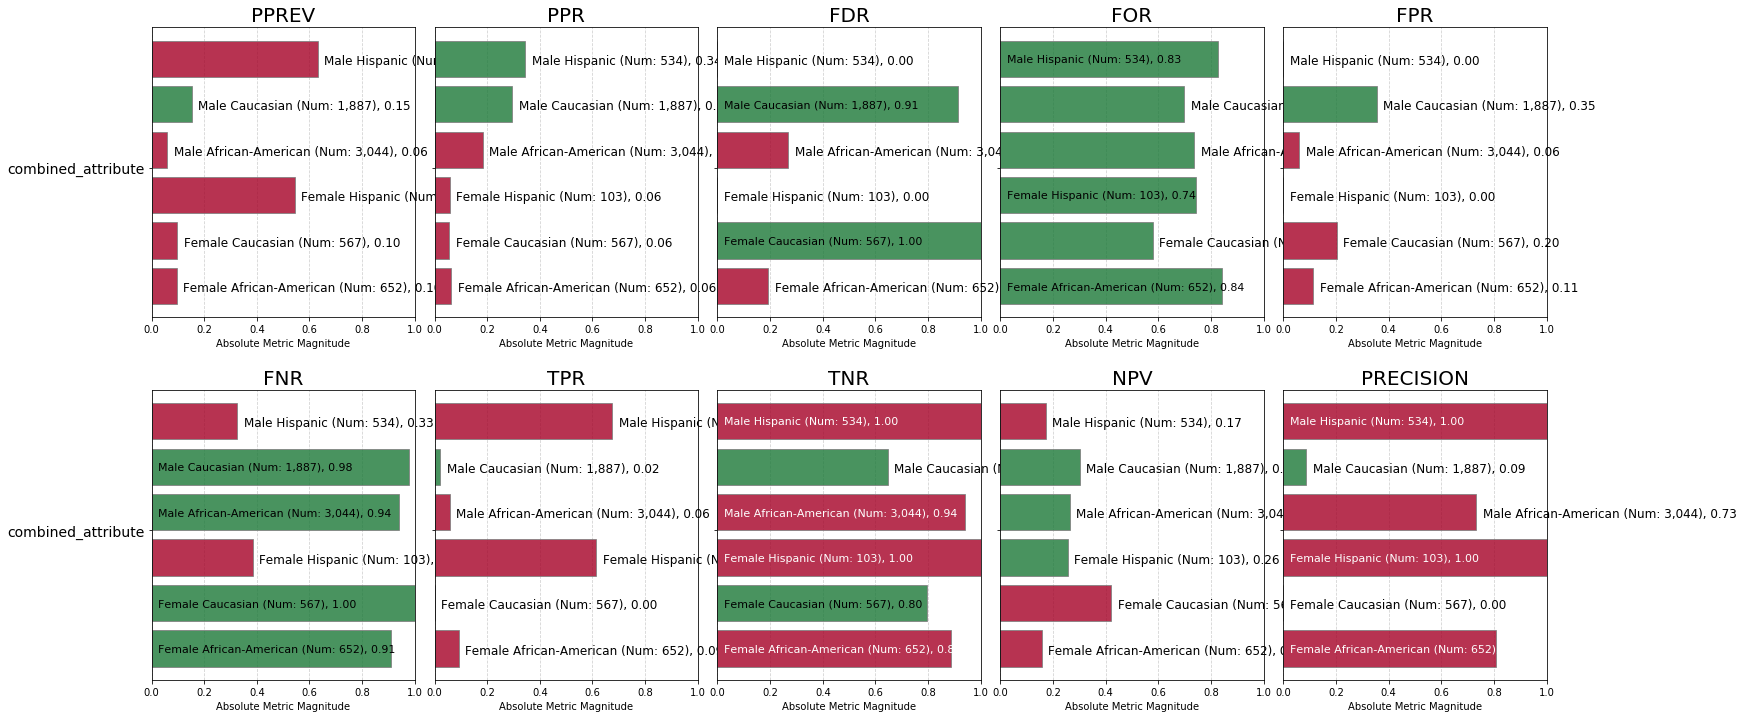

<Figure size 432x288 with 0 Axes>

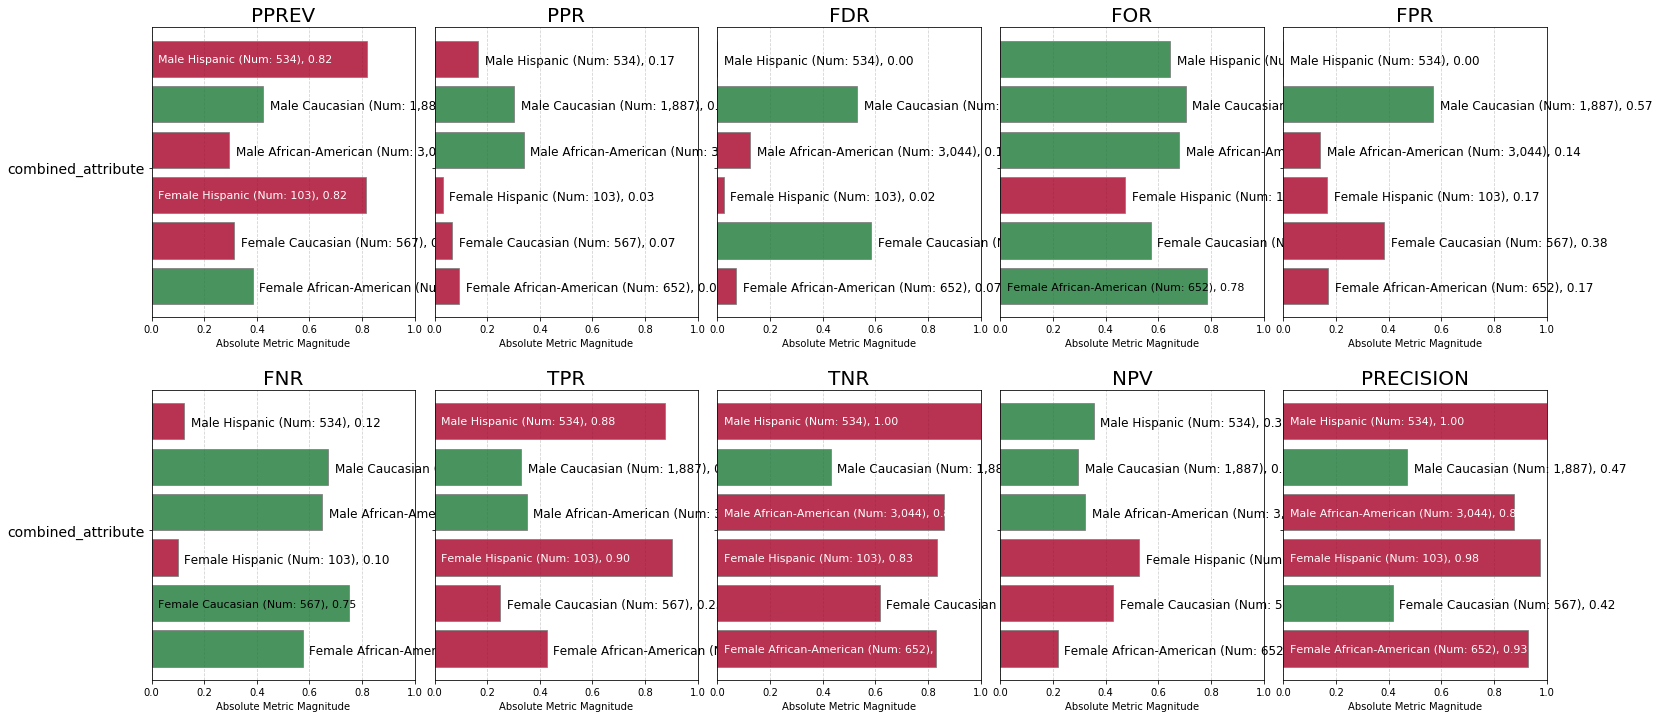

<Figure size 432x288 with 0 Axes>

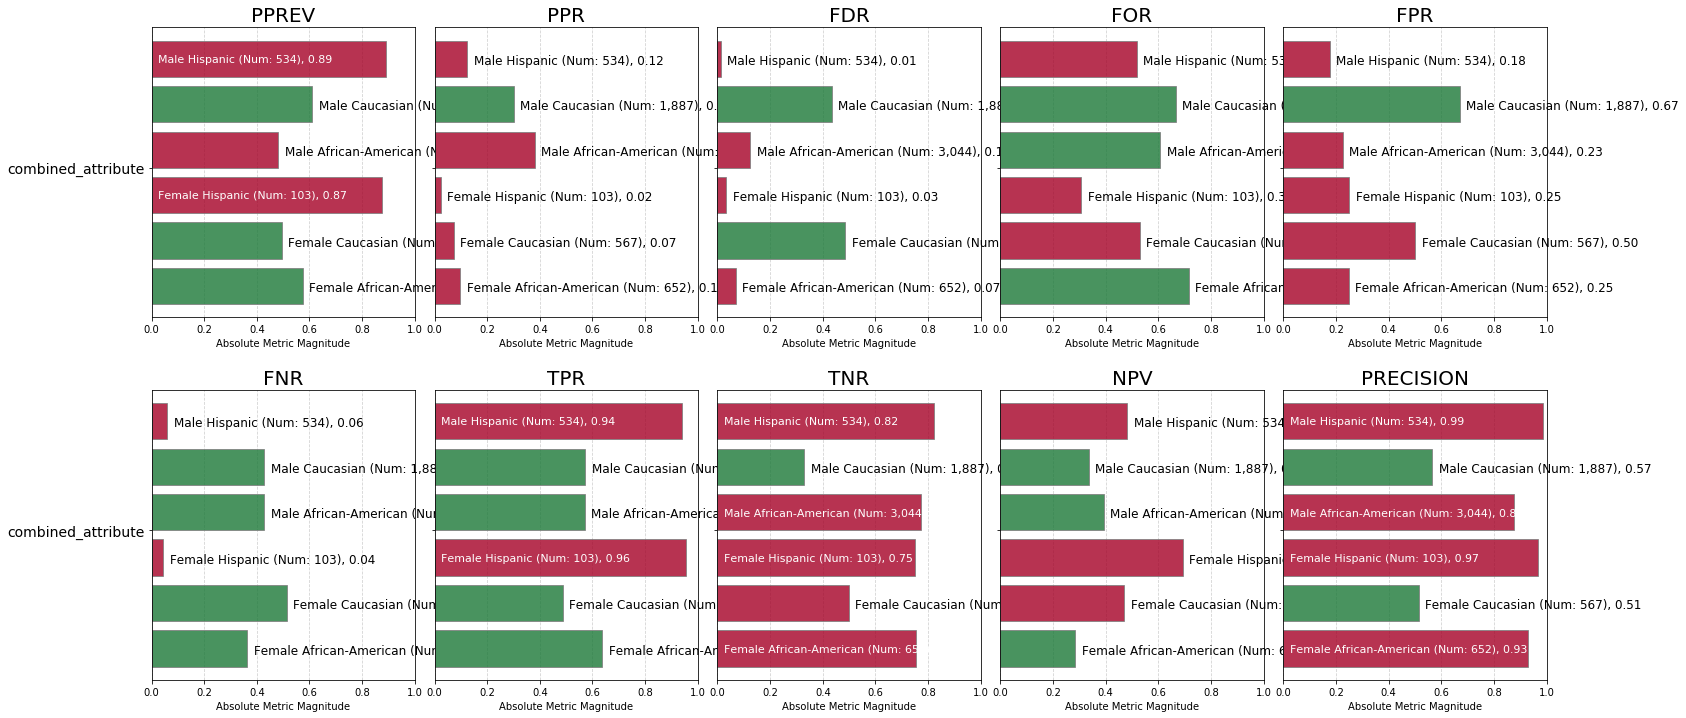

<Figure size 432x288 with 0 Axes>

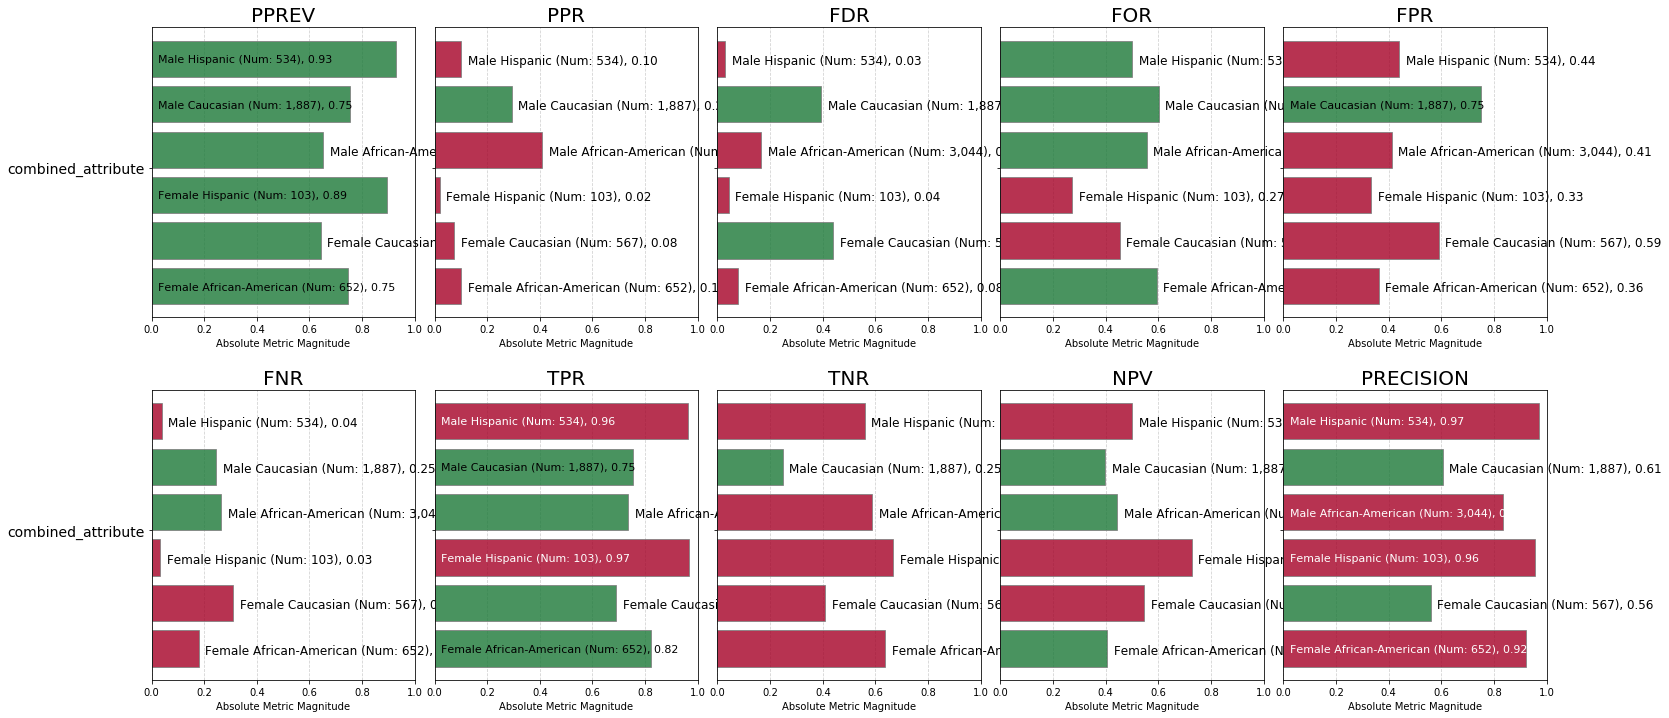

<Figure size 432x288 with 0 Axes>

In [34]:
aqp = Plot()
i = 0.1
for table in complete_tables:
    fdf = f.get_group_value_fairness(table)
    plot = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")
    plot.savefig('graphics/ethnicity_endpoint_disparities_{}.pdf'.format(i), format='pdf')
    i = i + 0.1